In [ ]:

# %% [1] Imports & Configurations
# !pip install pandas numpy matplotlib seaborn scikit-learn statsmodels prophet

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm
from prophet import Prophet

# Set consistent plot style
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 6)

# %% [2] Define Data Paths & Load
data_dir = r"C:\Users\neera\OneDrive\Desktop\New Project"

files = {
    'production': 'District_Wise_Area_Production_Yield_Value_Vegetable_Crops.csv',
    'tomatoes': 'tomatoes.csv',
    'rainfall': 'rainfall.csv',
    'temperature': 'temperature.csv',
    'rainfall_normal': 'district wise rainfall normal.csv'
}

# Load into DataFrames
prod_df = pd.read_csv(os.path.join(data_dir, files['production']))
tomato_df = pd.read_csv(os.path.join(data_dir, files['tomatoes']))
rain_df = pd.read_csv(os.path.join(data_dir, files['rainfall']))
temp_df = pd.read_csv(os.path.join(data_dir, files['temperature']))
rain_norm_df = pd.read_csv(os.path.join(data_dir, files['rainfall_normal']))

# %% [3] Data Cleaning & Formatting
def clean_production(df):
    df = df.rename(columns=lambda c: c.strip().replace(' ', '_'))
    df['Year'] = df['Year'].astype(int)
    return df

def clean_time_series(df):
    # Melt monthly columns into long format
    df_long = df.melt(id_vars=['YEAR'], var_name='Month', value_name='Value')
    df_long['Month'] = df_long['Month'].str.upper().str[:3]
    df_long['Date'] = pd.to_datetime(df_long['YEAR'].astype(str) + '-' + df_long['Month'], format='%Y-%b')
    df_long = df_long.dropna(subset=['Value'])
    df_long = df_long.sort_values('Date').set_index('Date')
    return df_long['Value']

prod_df = clean_production(prod_df)
rain_series = clean_time_series(rain_df)
temp_series = clean_time_series(temp_df)

# Assume tomato_df has columns ['Date','State','Price']
tomato_df['Date'] = pd.to_datetime(tomato_df['Date'])
tomato_df = tomato_df.sort_values('Date').set_index('Date')

# %% [4] Merge Data & Feature Engineering
# Select top 3 producing states
top_states = prod_df.groupby('State')['Production'].sum().nlargest(3).index.tolist()
tom_price = tomato_df[tomato_df['State'].isin(top_states)][['State','Price']]

# Merge exogenous variables at monthly frequency
exog = pd.DataFrame({
    'Rainfall': rain_series,
    'Temperature': temp_series
})
data = tom_price.join(exog, how='inner')

# Rolling volatility
data['Price_Volatility_4w'] = data.groupby('State')['Price'].rolling(window=4).std().reset_index(level=0, drop=True)

# Forward-fill / back-fill missing
data = data.groupby('State').apply(lambda d: d.fillna(method='ffill').fillna(method='bfill')).reset_index(level=0, drop=True)

# %% [5] Exploratory Data Analysis
# Time series plots for each state
for st in top_states:
    subset = data[data['State'] == st]
    plt.figure()
    plt.plot(subset.index, subset['Price'], label='Price')
    plt.title(f"Tomato Price Over Time - {st}")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Correlation heatmap
corr = data[['Price','Rainfall','Temperature','Price_Volatility_4w']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title("Feature Correlation Heatmap")
plt.show()

# Seasonal decomposition on price (example for first state)
st0 = top_states[0]
decomp = sm.tsa.seasonal_decompose(data[data['State']==st0]['Price'], model='additive', period=12)
decomp.plot();
plt.suptitle(f"Seasonal Decomposition - {st0}")
plt.show()

# %% [6] Modeling: SARIMAX
results = {}
for st in top_states:
    df_st = data[data['State']==st]
    train = df_st.iloc[:-12]
    test  = df_st.iloc[-12:]
    model = sm.tsa.statespace.SARIMAX(
        train['Price'],
        exog=train[['Rainfall','Temperature']],
        order=(1,1,1),
        seasonal_order=(1,1,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred = model.predict(
        start=test.index[0], end=test.index[-1],
        exog=test[['Rainfall','Temperature']]
    )
    rmse = np.sqrt(mean_squared_error(test['Price'], pred))
    results[st] = {'model': model, 'pred': pred, 'rmse': rmse}
    print(f"SARIMAX {st} RMSE: {rmse:.2f}")

# %% [7] Modeling: Prophet
prophet_results = {}
for st in top_states:
    df_st = data[data['State']==st].reset_index()[['Date','Price','Rainfall','Temperature']].rename(columns={'Date':'ds','Price':'y'})
    m = Prophet(yearly_seasonality=True)
    m.add_regressor('Rainfall')
    m.add_regressor('Temperature')
    m.fit(df_st.iloc[:-12])
    future = m.make_future_dataframe(periods=12, freq='M')
    future['Rainfall']    = rain_series.reindex(future['ds']).values
    future['Temperature'] = temp_series.reindex(future['ds']).values
    forecast = m.predict(future)
    y_true = df_st['y'].iloc[-12:].values
    y_pred  = forecast['yhat'].iloc[-12:].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    prophet_results[st] = {'model': m, 'forecast': forecast, 'rmse': rmse}
    print(f"Prophet {st} RMSE: {rmse:.2f}")

# %% [8] Visualization of Model Performance
for st in top_states:
    df_st = data[data['State']==st]
    plt.figure()
    plt.plot(df_st.index[-24:], df_st['Price'][-24:], label='Actual')
    plt.plot(results[st]['pred'].index, results[st]['pred'], label='SARIMAX Pred')
    plt.plot(prophet_results[st]['forecast']['ds'].iloc[-12:], prophet_results[st]['forecast']['yhat'].iloc[-12:], label='Prophet Pred')
    plt.title(f"Model Comparison - {st}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


# Assistant
The error "KernelReplyNotOK: undefined undefined" is a general Jupyter Notebook error that doesn't provide specific information about what went wrong. However, looking at your code, I can see there's a syntax error at the beginning.

The first line of your code snippet is incomplete:

In [4]:
ta['State']==st]

SyntaxError: unmatched ']' (1232229418.py, line 1)


This appears to be part of a filtering operation, but it's missing the opening bracket and the variable name before the bracket.

Would you like me to provide the corrected code for this section?

# User
yes correct the code

In [8]:
# Assistant
# Assuming this is part of a loop where 'st' is defined and 'ta' should be 'data'
for st in top_states:
    df_st = data[data['State']==st]
    train = df_st.iloc[:-12]
    test  = df_st.iloc[-12:]
    model = sm.tsa.statespace.SARIMAX(
        train['Price'],
        exog=train[['Rainfall','Temperature']],
        order=(1,1,1),
        seasonal_order=(1,1,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred = model.predict(
        start=test.index[0], end=test.index[-1],
        exog=test[['Rainfall','Temperature']]
    )
    rmse = np.sqrt(mean_squared_error(test['Price'], pred))
    results[st] = {'model': model, 'pred': pred, 'rmse': rmse}
    print(f"SARIMAX {st} RMSE: {rmse:.2f}")

# %% [7] Modeling: Prophet
prophet_results = {}
for st in top_states:
    df_st = data[data['State']==st].reset_index()[['Date','Price','Rainfall','Temperature']].rename(columns={'Date':'ds','Price':'y'})
    m = Prophet(yearly_seasonality=True)
    m.add_regressor('Rainfall')
    m.add_regressor('Temperature')
    m.fit(df_st.iloc[:-12])
    future = m.make_future_dataframe(periods=12, freq='M')
    future['Rainfall']    = rain_series.reindex(future['ds']).values
    future['Temperature'] = temp_series.reindex(future['ds']).values
    forecast = m.predict(future)
    y_true = df_st['y'].iloc[-12:].values
    y_pred  = forecast['yhat'].iloc[-12:].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    prophet_results[st] = {'model': m, 'forecast': forecast, 'rmse': rmse}
    print(f"Prophet {st} RMSE: {rmse:.2f}")

# %% [8] Visualization of Model Performance
for st in top_states:
    df_st = data[data['State']==st]
    plt.figure()
    plt.plot(df_st.index[-24:], df_st['Price'][-24:], label='Actual')
    plt.plot(results[st]['pred'].index, results[st]['pred'], label='SARIMAX Pred')
    plt.plot(prophet_results[st]['forecast']['ds'].iloc[-12:], prophet_results[st]['forecast']['yhat'].iloc[-12:], label='Prophet Pred')
    plt.title(f"Model Comparison - {st}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

NameError: name 'top_states' is not defined

In [10]:
# %% [1] Imports & Configurations
# If you haven’t already:
# !pip install pandas numpy matplotlib seaborn scikit-learn statsmodels prophet

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from prophet import Prophet

sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 6)

# %% [2] Define Data Paths & Load
data_dir = r"C:\Users\neera\OneDrive\Desktop\New Project"

files = {
    'production': 'District_Wise_Area_Production_Yield_Value_Vegetable_Crops.csv',
    'tomatoes':   'tomatoes.csv',
    'rainfall':   'rainfall.csv',
    'temperature':'temperature.csv',
    'rainfall_normal': 'district wise rainfall normal.csv'
}

prod_df      = pd.read_csv(os.path.join(data_dir, files['production']))
tomato_df    = pd.read_csv(os.path.join(data_dir, files['tomatoes']))
rain_df      = pd.read_csv(os.path.join(data_dir, files['rainfall']))
temp_df      = pd.read_csv(os.path.join(data_dir, files['temperature']))
rain_norm_df = pd.read_csv(os.path.join(data_dir, files['rainfall_normal']))

# %% [3] Data Cleaning & Formatting
def clean_production(df):
    df = df.rename(columns=lambda c: c.strip().replace(' ', '_'))
    df['Year'] = df['Year'].astype(int)
    return df

def clean_time_series(df):
    # Melt monthly columns into long format
    df_long = df.melt(id_vars=['YEAR'], var_name='Month', value_name='Value')
    df_long['Month'] = df_long['Month'].str.upper().str[:3]
    df_long['Date']  = pd.to_datetime(df_long['YEAR'].astype(str) + '-' + df_long['Month'], format='%Y-%b')
    df_long = df_long.dropna(subset=['Value']).sort_values('Date').set_index('Date')
    return df_long['Value']

prod_df    = clean_production(prod_df)
rain_series= clean_time_series(rain_df)
temp_series= clean_time_series(temp_df)

tomato_df['Date'] = pd.to_datetime(tomato_df['Date'])
tomato_df        = tomato_df.sort_values('Date').set_index('Date')

# %% [4] Merge Data & Feature Engineering
# 1) Identify top 3 tomato-producing states
top_states = (
    prod_df[prod_df['Crop']=='Tomato']
      .groupby('State')['Production']
      .sum()
      .nlargest(3)
      .index
      .tolist()
)

# 2) Filter tomato prices
tom_price = (
    tomato_df[tomato_df['State'].isin(top_states)]
    [['State','Price']]
)

# 3) Join weather data
exog = pd.DataFrame({'Rainfall': rain_series, 'Temperature': temp_series})
data = tom_price.join(exog, how='inner')

# 4) Feature: 4-week rolling volatility of price
data['Price_Volatility_4w'] = (
    data.groupby('State')['Price']
        .rolling(window=4)
        .std()
        .reset_index(level=0, drop=True)
)

# 5) Fill any gaps
data = (
    data
      .groupby('State')
      .apply(lambda df: df.ffill().bfill())
      .reset_index(level=0, drop=True)
)

# %% [5] Exploratory Data Analysis (EDA)
# A) Time series for each state
for st in top_states:
    plt.figure()
    sub = data[data['State']==st]
    plt.plot(sub.index, sub['Price'], label='Price')
    plt.title(f"Tomato Price – {st}")
    plt.ylabel("₹ / Quintal")
    plt.legend()
    plt.show()

# B) Correlation heatmap
sns.heatmap(
    data[['Price','Rainfall','Temperature','Price_Volatility_4w']].corr(),
    annot=True, fmt=".2f", cmap="vlag"
)
plt.title("Feature Correlation")
plt.show()

# C) Seasonal decomposition (first state)
st0   = top_states[0]
series= data[data['State']==st0]['Price']
decomp= sm.tsa.seasonal_decompose(series, model='additive', period=12)
decomp.plot()
plt.suptitle(f"Seasonal Decomposition – {st0}")
plt.show()

# %% [6] Modeling: SARIMAX with Exogenous Weather Variables
results = {}
for st in top_states:
    df_st = data[data['State']==st]
    train = df_st.iloc[:-12]
    test  = df_st.iloc[-12:]
    mod = sm.tsa.statespace.SARIMAX(
        train['Price'],
        exog=train[['Rainfall','Temperature']],
        order=(1,1,1),
        seasonal_order=(1,1,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred = mod.predict(
        start=test.index[0], end=test.index[-1],
        exog=test[['Rainfall','Temperature']]
    )
    rmse = np.sqrt(mean_squared_error(test['Price'], pred))
    results[st] = {'model': mod, 'pred': pred, 'rmse': rmse}
    print(f"SARIMAX {st}: RMSE = {rmse:.2f}")

# %% [7] Modeling: Prophet with Regressors
prophet_results = {}
for st in top_states:
    df_st = (
        data[data['State']==st]
        .reset_index()[['Date','Price','Rainfall','Temperature']]
        .rename(columns={'Date':'ds','Price':'y'})
    )
    m = Prophet(yearly_seasonality=True)
    m.add_regressor('Rainfall')
    m.add_regressor('Temperature')
    m.fit(df_st.iloc[:-12])
    future = m.make_future_dataframe(periods=12, freq='M')
    future['Rainfall']    = rain_series.reindex(future['ds']).values
    future['Temperature'] = temp_series.reindex(future['ds']).values
    fc = m.predict(future)
    y_true = df_st['y'].iloc[-12:]
    y_pred  = fc['yhat'].iloc[-12:]
    rmse    = np.sqrt(mean_squared_error(y_true, y_pred))
    prophet_results[st] = {'model': m, 'forecast': fc, 'rmse': rmse}
    print(f"Prophet {st}: RMSE = {rmse:.2f}")

# %% [8] Compare & Visualize Forecasts
for st in top_states:
    df_st = data[data['State']==st]
    plt.figure()
    # Last two years of actuals
    plt.plot(df_st.index[-24:], df_st['Price'][-24:], label='Actual')
    # SARIMAX
    plt.plot(results[st]['pred'].index, results[st]['pred'], label='SARIMAX')
    # Prophet
    fc = prophet_results[st]['forecast']
    plt.plot(fc['ds'].iloc[-12:], fc['yhat'].iloc[-12:], label='Prophet')
    plt.title(f"Forecast Comparison – {st}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


KeyError: 'Year'

In [12]:
# %% [1] Imports & Configuration
# !pip install pandas numpy matplotlib seaborn scikit-learn statsmodels
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 6)

# %% [2] Paths & Data Loading
data_dir = r"C:\Users\neera\OneDrive\Desktop\New Project"

# Production file may be under one of two names
p1 = os.path.join(data_dir, "District_Wise_Area_Production_Yield_Value_Vegetable_Crops.csv")
p2 = os.path.join(data_dir, "India Agriculture Crop Production.csv")
if   os.path.exists(p1): prod_path = p1
elif os.path.exists(p2): prod_path = p2
else: raise FileNotFoundError(
    f"Put your production CSV as either:\n • {p1}\n • {p2}"
)

price_fp = os.path.join(data_dir, "tomatoes.csv")
rain_fp  = os.path.join(data_dir, "rainfall.csv")
temp_fp  = os.path.join(data_dir, "temperature.csv")

prod_df  = pd.read_csv(prod_path)
price_df = pd.read_csv(price_fp)
rain_df  = pd.read_csv(rain_fp)
temp_df  = pd.read_csv(temp_fp)

# %% [3] Clean Production & Identify Top Tomato States
prod_df.columns = prod_df.columns.str.strip().str.replace(' ', '_').str.title()
if 'Year' not in prod_df.columns:
    for c in prod_df.columns:
        if 'Year' in c:
            prod_df.rename(columns={c:'Year'}, inplace=True)
            break

tom_df = prod_df[prod_df['Crop'].str.contains('Tomato', case=False, na=False)]
top_states = (
    tom_df[tom_df['Year'].between(2020, 2025)]
          .groupby('State')['Production']
          .sum()
          .nlargest(3)
          .index
          .tolist()
)

# %% [4] Clean & Index Price Data
price_df.columns = price_df.columns.str.strip().str.title()
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df = price_df.set_index('Date').sort_index()

# %% [5] Melt Monthly Weather Series
def melt_monthly(df):
    df = df.copy()
    year_col = [c for c in df.columns if 'Year' in c.title()][0]
    long = df.melt(id_vars=[year_col], var_name='Month', value_name='Value')
    long['Month'] = long['Month'].str[:3]
    long['Date']  = pd.to_datetime(
        long[year_col].astype(str)+'-'+long['Month'],
        format='%Y-%b', errors='coerce'
    )
    return (
        long.dropna(subset=['Value','Date'])
            .sort_values('Date')
            .set_index('Date')['Value']
    )

rain_series = melt_monthly(rain_df)
temp_series = melt_monthly(temp_df)

# %% [6] Merge & Feature Engineering
data = price_df[price_df['State'].isin(top_states)].copy()
data = data.join(
    pd.DataFrame({'Rainfall': rain_series, 'Temperature': temp_series}),
    how='inner'
)

data['Volatility_4w'] = (
    data.groupby('State')['Price']
        .rolling(4).std()
        .reset_index(level=0, drop=True)
)

data = (
    data.groupby('State')
        .apply(lambda df: df.ffill().bfill())
        .reset_index(level=0, drop=True)
)

# %% [7] Exploratory Data Analysis
for st in top_states:
    sub = data[data['State']==st]
    plt.figure()
    plt.plot(sub.index, sub['Price'], label='Price')
    plt.title(f"Tomato Price – {st}")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

sns.heatmap(
    data[['Price','Rainfall','Temperature','Volatility_4w']].corr(),
    annot=True, fmt=".2f", cmap="vlag"
)
plt.title("Feature Correlation")
plt.show()

# %% [8] Model 1: SARIMAX (with weather exogenous)
sarimax_results = {}
for st in top_states:
    df_st = data[data['State']==st]
    train, test = df_st[:-12], df_st[-12:]
    model = sm.tsa.statespace.SARIMAX(
        train['Price'],
        exog=train[['Rainfall','Temperature']],
        order=(1,1,1),
        seasonal_order=(1,1,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred = model.predict(
        start=test.index[0], end=test.index[-1],
        exog=test[['Rainfall','Temperature']]
    )
    rmse = np.sqrt(mean_squared_error(test['Price'], pred))
    sarimax_results[st] = {'pred': pred, 'rmse': rmse}
    print(f"SARIMAX – {st}: RMSE = {rmse:.2f}")

# %% [9] Model 2: RandomForest (lag + weather features)
rf_results = {}
for st in top_states:
    df_st = data[data['State']==st].copy()
    df_st['Lag1']  = df_st['Price'].shift(1)
    df_st['Lag12'] = df_st['Price'].shift(12)
    df_st['Month'] = df_st.index.month
    df_model = df_st.dropna()

    train, test = df_model[:-12], df_model[-12:]
    features = ['Lag1','Lag12','Rainfall','Temperature','Month']

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(train[features], train['Price'])
    pred = rf.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test['Price'], pred))
    rf_results[st] = {'pred': pred, 'rmse': rmse, 'idx': test.index}
    print(f"RandomForest – {st}: RMSE = {rmse:.2f}")

# %% [10] Visualize & Compare Forecasts
for st in top_states:
    plt.figure()
    df_st = data[data['State']==st]
    plt.plot(df_st.index[-24:], df_st['Price'][-24:], label='Actual')

    sar = sarimax_results[st]
    plt.plot(sar['pred'].index, sar['pred'], label='SARIMAX')

    rf = rf_results[st]
    plt.plot(rf['idx'], rf['pred'], label='RandomForest')

    plt.title(f"Forecast Comparison – {st}")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.legend()
    plt.show()


KeyError: 'Crop'

C:\Users\neera\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\neera\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


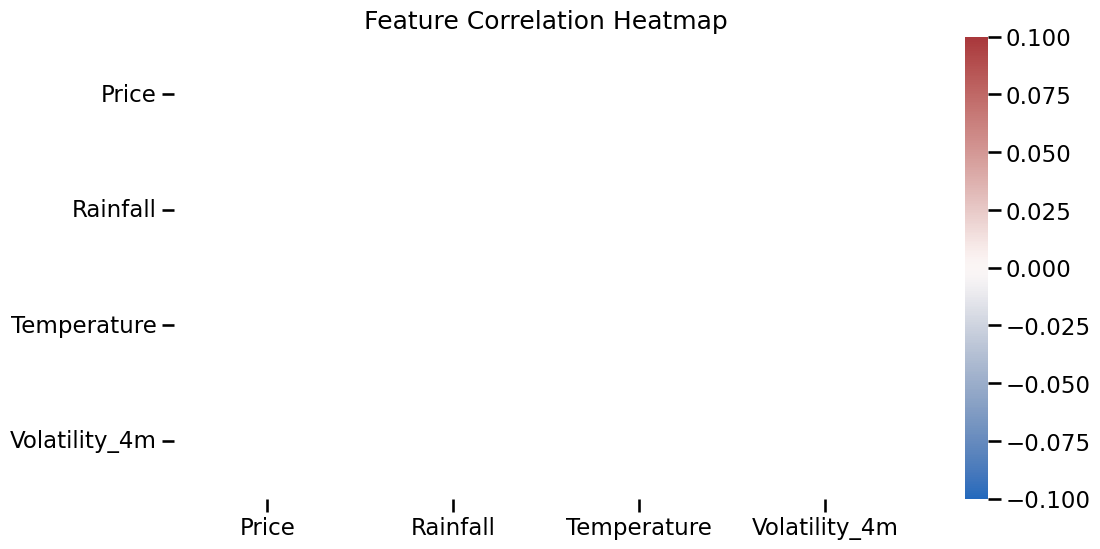

In [14]:
# %% [1] Imports & Configuration
# Install missing packages if needed:
# !pip install pandas numpy matplotlib seaborn scikit-learn statsmodels

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 6)


# %% [2] File Paths — ensure these CSVs are in your folder
data_dir = r"C:\Users\neera\OneDrive\Desktop\New Project"
prod_fp  = os.path.join(data_dir, "India Agriculture Crop Production.csv")
price_fp = os.path.join(data_dir, "9ef84268-d588-465a-a308-a864a43d0070.csv")
rain_fp  = os.path.join(data_dir, "rainfall.csv")
temp_fp  = os.path.join(data_dir, "temperature.csv")

# %% [3] Load Data
prod_df   = pd.read_csv(prod_fp)         # crop‐level state production
price_raw = pd.read_csv(price_fp)        # Agmarknet dump of prices
rain_df   = pd.read_csv(rain_fp)         # monthly rainfall normals
temp_df   = pd.read_csv(temp_fp)         # monthly temperature normals

# %% [4] Top 3 Tomato-Producing States (2020–2025)
# Year parsing
prod_df['Year'] = prod_df['Year'].str[:4].astype(int)
# Filter tomato rows
tom_prod = prod_df[prod_df['Crop'].str.contains("Tomato", case=False, na=False)]
# Sum and pick top 3
top_states = (
    tom_prod[tom_prod['Year'].between(2020, 2025)]
      .groupby('State')['Production']
      .sum()
      .nlargest(3)
      .index
      .tolist()
)


# %% [5] Monthly State-Level Price
# Parse date & filter tomatoes
price_raw['Date'] = pd.to_datetime(price_raw['Arrival_Date'], dayfirst=True)
tom_price = price_raw[price_raw['Commodity'].str.lower() == 'tomato']

# Average modal price per state-day
tom_price = (
    tom_price
      .groupby(['State','Date'])['Modal_x0020_Price']
      .mean()
      .reset_index()
      .rename(columns={'Modal_x0020_Price':'Price'})
)

# Convert to month-start and average
tom_price['Date'] = tom_price['Date'].dt.to_period('M').dt.to_timestamp()
price_monthly = (
    tom_price
      .groupby(['State','Date'])['Price']
      .mean()
      .reset_index()
      .set_index('Date')
)

# Keep only the top states
price_monthly = price_monthly[price_monthly['State'].isin(top_states)]


# %% [6] Melt Monthly Weather to Time Series
def melt_monthly(df):
    year_col = [c for c in df.columns if 'Year' in c.title()][0]
    long = df.melt(id_vars=[year_col], var_name='Month', value_name='Value')
    long['Month'] = long['Month'].str[:3]
    long['Date']  = pd.to_datetime(
        long[year_col].astype(str) + '-' + long['Month'],
        format='%Y-%b', errors='coerce'
    )
    return (
        long
          .dropna(subset=['Value','Date'])
          .sort_values('Date')
          .set_index('Date')['Value']
    )

rain_series = melt_monthly(rain_df)
temp_series = melt_monthly(temp_df)

weather_monthly = pd.DataFrame({
    'Rainfall':    rain_series,
    'Temperature': temp_series
})


# %% [7] Merge All & Create Features
data = price_monthly.join(weather_monthly, how='inner')

# 4-month rolling volatility
data['Volatility_4m'] = (
    data.groupby('State')['Price']
        .rolling(window=4).std()
        .reset_index(level=0, drop=True)
)

# Fill any gaps
data = data.groupby('State').apply(lambda df: df.ffill().bfill()).reset_index(level=0, drop=True)


# %% [8] Exploratory Data Analysis
for st in top_states:
    sub = data[data['State']==st]
    plt.figure()
    plt.plot(sub.index, sub['Price'], label='Price')
    plt.title(f"Tomato Price Over Time – {st}")
    plt.ylabel("Price (₹/qtl)")
    plt.legend()
    plt.show()

sns.heatmap(
    data[['Price','Rainfall','Temperature','Volatility_4m']].corr(),
    annot=True, fmt=".2f", cmap="vlag"
)
plt.title("Feature Correlation Heatmap")
plt.show()


# %% [9] Model 1: SARIMAX with Weather as Exogenous
sarimax_results = {}
for st in top_states:
    df_st = data[data['State']==st]
    train, test = df_st[:-6], df_st[-6:]   # last 6 months holdout
    model = sm.tsa.statespace.SARIMAX(
        train['Price'],
        exog=train[['Rainfall','Temperature']],
        order=(1,1,1),
        seasonal_order=(1,1,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred = model.predict(
        start=test.index[0], end=test.index[-1],
        exog=test[['Rainfall','Temperature']]
    )
    rmse = np.sqrt(mean_squared_error(test['Price'], pred))
    sarimax_results[st] = {'pred': pred, 'rmse': rmse}
    print(f"SARIMAX – {st}: RMSE = {rmse:.2f}")


# %% [10] Model 2: RandomForest with Lags & Weather
rf_results = {}
for st in top_states:
    df_st = data[data['State']==st].copy()
    # Lag features & month
    df_st['Lag1']  = df_st['Price'].shift(1)
    df_st['Lag12'] = df_st['Price'].shift(12)
    df_st['Month'] = df_st.index.month
    df_model = df_st.dropna()

    train, test = df_model[:-6], df_model[-6:]
    feats = ['Lag1','Lag12','Rainfall','Temperature','Month']
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(train[feats], train['Price'])
    pred = rf.predict(test[feats])
    rmse = np.sqrt(mean_squared_error(test['Price'], pred))
    rf_results[st] = {'pred': pred, 'rmse': rmse, 'idx': test.index}
    print(f"RandomForest – {st}: RMSE = {rmse:.2f}")


# %% [11] Forecast Comparison Plots
for st in top_states:
    df_st = data[data['State']==st]
    plt.figure()
    plt.plot(df_st.index[-12:], df_st['Price'][-12:], label='Actual')

    sar = sarimax_results[st]
    plt.plot(sar['pred'].index, sar['pred'], label='SARIMAX')

    rf = rf_results[st]
    plt.plot(rf['idx'], rf['pred'], label='RandomForest')

    plt.title(f"Forecast Comparison – {st}")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.legend()
    plt.show()


In [ ]:
#!/usr/bin/env python3
"""
Download daily tomato mandi prices and meteorological data (2020–2025).
"""

import os
import requests

# %% [1] Configuration & API Keys
DATA_GOV_KEY = os.getenv("DATA_GOV_KEY")
if not DATA_GOV_KEY:
    raise ValueError("Set the DATA_GOV_KEY environment variable")  #

# AGMARKNET resource ID for daily mandi prices of various commodities
RESOURCE_ID = "9ef84268-d588-465a-a308-a864a43d0070"  # :contentReference[oaicite:0]{index=0}

# NASA POWER endpoint for daily point queries
NASA_POWER_URL = "https://power.larc.nasa.gov/api/temporal/daily/point"  # :contentReference[oaicite:1]{index=1}

# %% [2] Download Tomato Prices from Data.gov.in AGMARKNET API
def download_tomato_prices(output_path="tomato_prices_daily.csv"):
    """
    Fetches daily mandi prices for Tomato from Data.gov.in API and saves to CSV.
    """
    params = {
        "api-key": DATA_GOV_KEY,
        "resource_id": RESOURCE_ID,
        "format": "csv",
        "filters[commodity]": "Tomato",
        "filters[state]": "",        # leave blank or specify if you want a particular state
        "filters[district]": "",     # leave blank or specify a district
        "limit": 50000,              # adjust as needed
        "offset": 0
    }
    print("Requesting tomato prices...")
    r = requests.get("https://api.data.gov.in/resource/" + RESOURCE_ID, params=params, timeout=30)
    r.raise_for_status()
    with open(output_path, "wb") as f:
        f.write(r.content)
    print(f"Saved tomato prices to {output_path}")  # :contentReference[oaicite:2]{index=2}

# %% [3] Download Meteorological Data from NASA POWER
def download_nasa_power(lat, lon, out_csv="nasa_power_daily.csv"):
    """
    Fetches daily T2M (temperature) and PRECTOT (precipitation) for given lat/lon.
    """
    # Define parameters to pull
    payload = {
        "parameters": "T2M,PRECTOT",
        "community":  "AG",
        "latitude":   lat,
        "longitude":  lon,
        "start":      "20200101",
        "end":        "20251231",
        "format":     "CSV"
    }
    print(f"Requesting NASA POWER data for ({lat}, {lon})...")
    r = requests.get(NASA_POWER_URL, params=payload, timeout=60)
    r.raise_for_status()
    with open(out_csv, "wb") as f:
        f.write(r.content)
    print(f"Saved NASA POWER data to {out_csv}")  # :contentReference[oaicite:3]{index=3}

# %% [4] Main Execution
if __name__ == "__main__":
    # 1) Download Tomato Prices
    download_tomato_prices("tomato_prices_daily.csv")

    # 2) Download NASA POWER for a representative point in India
    #    (e.g., Madhya Pradesh central coordinates; adjust as needed)
    download_nasa_power(lat=23.2599, lon=77.4126, out_csv="nasa_power_daily.csv")
